In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy import optimize, interpolate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.optimize import basinhopping

In [3]:
# /data/df.pickleの読み込み
df = pd.read_pickle('../data/df.pickle')

df = df.dropna()

# データの分割
df_p1 = df[(df['started_at'] >= '2020-03-01') & (df['started_at'] < '2020-06-01')].dropna()
df_p2 = df[(df['started_at'] >= '2020-06-01') & (df['started_at'] < '2020-11-01')].dropna()
df_p3 = df[(df['started_at'] >= '2020-12-01') & (df['started_at'] < '2021-03-01')].dropna()
df_p4 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2023-10-01')].dropna()
df_p4_1 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2022-01-01')].dropna()
df_p4_2 = df[(df['started_at'] >= '2022-01-01') & (df['started_at'] < '2023-10-01')].dropna()
df_left = pd.concat([df_p1, df_p2, df_p3, df_p4_1], axis=0)
df_right = pd.concat([df_p4_2], axis=0)

In [4]:
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    # node_listとedge_listで0の値を削除
    node_list = np.array(node_list)
    edge_list = np.array(edge_list)
    timestamp = np.array(timestamp)
    active_node_list = node_list[node_list != 0]
    edge_list = edge_list[edge_list != 0]
    timestamp = timestamp[:len(node_list)]
    
    return active_node_list, edge_list, timestamp

In [5]:
node_left, edge_left, timestamp_left = return_nm(df_left)

In [6]:
# node_leftとedge_leftを組みにしてdf_leftを作成
df_left = pd.DataFrame({'node': node_left, 'edge': edge_left})
# df_leftのnodeを昇順にして並び替え
df_left = df_left.sort_values(by='node')
# インデックスを振り直す
df_left = df_left.reset_index(drop=True)
df_left.head()

,node,edge
0,106,190
1,136,221
2,173,312
3,215,368
4,217,494


In [44]:
# modelを定義
def model_uniform(x, kappa):
    m = x[0]
    kappa = np.abs(kappa)
    Np = (1 + np.sqrt(1 + ((32 * np.abs(m)) / np.abs(kappa))) ) / 2
    res = Np * (1 - (2 / (kappa * Np)) * (1 - ((1 - (kappa / 2)) ** Np) ))
    return res

In [58]:
# 残差関数の定義
def residual_uniform(params, x, y):
    return y - model_uniform(x, *params)

In [59]:
node_norm_left = df_left['node_norm'].values
edge_norm_left = df_left['edge_norm'].values

In [60]:
print("+------------------+")
print("| Estimating       |")
print("+------------------+")

result = optimize.least_squares(residual_uniform, x0=[0.1], args=(edge_norm_left, node_norm_left))
optimized_kappa = result.x

print(r"kappa:", optimized_kappa)

+------------------+
| Estimating       |
+------------------+
kappa: [2.38418579e-08]


In [15]:
# 正規化
df_left["node_norm"] = df_left["node"] - df_left["node"].min() + 2
df_left["edge_norm"] = df_left["edge"] - df_left["edge"].min() + 1

In [16]:
df_left.head()

,node,edge,node_norm,edge_norm
0,106,190,2,1
1,136,221,32,32
2,173,312,69,123
3,215,368,111,179
4,217,494,113,305


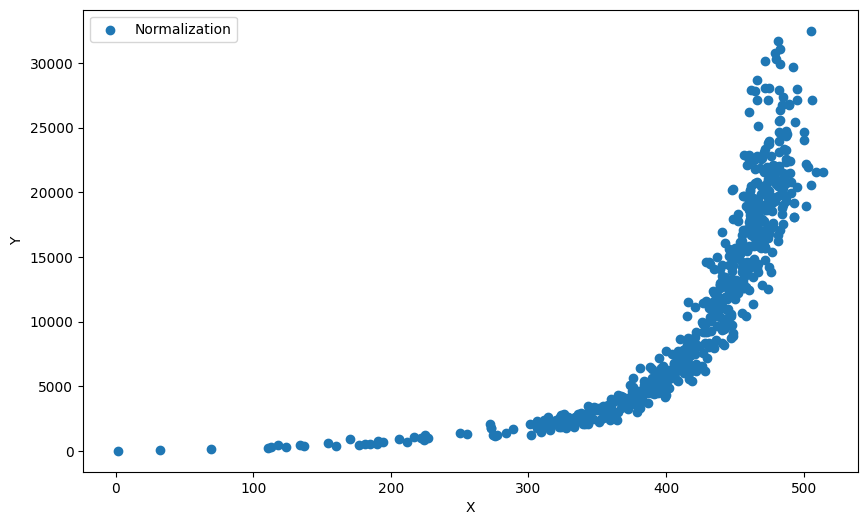

In [18]:
# 可視化
plt.figure(figsize=(10, 6))
plt.scatter(df_left["node_norm"], df_left["edge_norm"], label='Normalization')
plt.xlabel('X')
plt.ylabel('Y')
# plt.xscale('log')
# plt.yscale('log')
plt.legend(loc='best')
plt.show()